/tmp/ipykernel_3282927/3086694527.py:12: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions = pd.read_csv("transactions_aggregated.csv")
/tmp/ipykernel_3282927/3086694527.py:13: DtypeWarning: Columns (1,4,10,13,16,18,19,20,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  validators = pd.read_csv("validators_aggregated.csv")
/tmp/ipykernel_3282927/3086694527.py:54: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['momentum'] = merged['close'] - merged['close'].shift(3).fillna(method='bfill')
/tmp/ipykernel_3282927/3086694527.py:55: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['rolling_mean'] = merged['close'].rolling(window=3).mean().fillna(method='bfill')



Classification Report:
               precision    recall  f1-score   support

        High       0.88      0.70      0.78        20
         Low       0.86      0.83      0.85        30
      Medium       0.75      0.87      0.81        31

    accuracy                           0.81        81
   macro avg       0.83      0.80      0.81        81
weighted avg       0.82      0.81      0.81        81



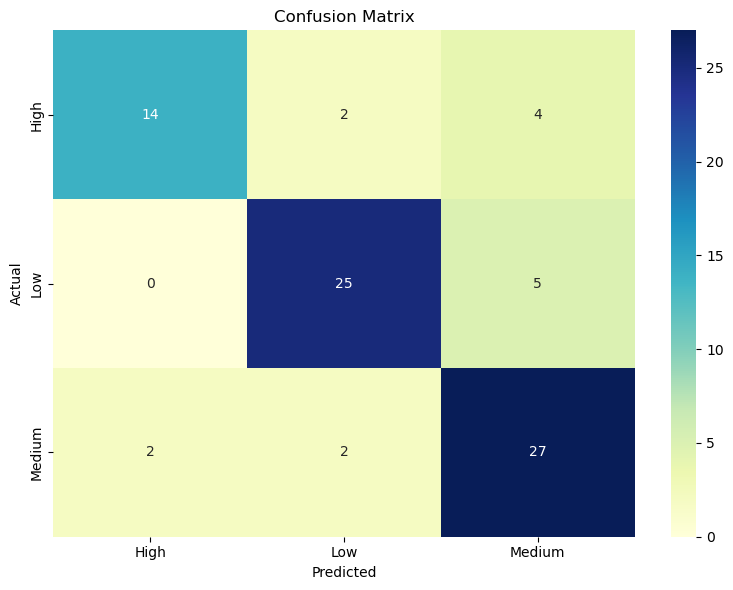

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load datasets
eth_price = pd.read_csv("ETH_USD_11_20_2020-1_19_2021_historical_prices (3).csv", sep=";")
transactions = pd.read_csv("transactions_aggregated.csv")
validators = pd.read_csv("validators_aggregated.csv")

# 2. Clean and preprocess ETH price data
eth_price['datetime'] = pd.to_datetime(eth_price['timestamp'], errors='coerce')
eth_price = eth_price[['datetime', 'close']].dropna()
eth_price['close'] = pd.to_numeric(eth_price['close'], errors='coerce')
eth_price.dropna(inplace=True)
eth_price['date'] = eth_price['datetime'].dt.date

# 3. Preprocess transactions
transactions['datetime'] = pd.to_datetime(transactions['datetime'], errors='coerce')
transactions['valueETH'] = pd.to_numeric(transactions['valueETH'], errors='coerce')
transactions['gasUsed'] = pd.to_numeric(transactions['gasUsed'], errors='coerce')
transactions.dropna(inplace=True)
tx_daily = transactions.groupby(transactions['datetime'].dt.date).agg({
    'valueETH': 'sum',
    'gasUsed': 'mean'
}).reset_index().rename(columns={'datetime': 'date'})

# 4. Preprocess validators
validators['datetime'] = pd.to_datetime(validators['datetime'], errors='coerce')
validators['valueETH'] = pd.to_numeric(validators['valueETH'], errors='coerce')
validators['gasUsed'] = pd.to_numeric(validators['gasUsed'], errors='coerce')
validators.dropna(inplace=True)
val_daily = validators.groupby(validators['datetime'].dt.date).agg({
    'valueETH': 'sum',
    'gasUsed': 'mean'
}).reset_index().rename(columns={'datetime': 'date'})
val_daily.columns = ['date', 'validator_valueETH', 'validator_gasUsed']

# 5. Merge datasets
merged = eth_price.merge(tx_daily, on='date', how='left')
merged = merged.merge(val_daily, on='date', how='left')
merged.fillna(0, inplace=True)

# 6. Feature engineering
merged['daily_return'] = merged['close'].pct_change().fillna(0)
merged['lag_return_1'] = merged['daily_return'].shift(1).fillna(0)
merged['lag_return_2'] = merged['daily_return'].shift(2).fillna(0)
merged['rolling_vol_3'] = merged['daily_return'].rolling(window=3).std().fillna(0)
merged['rolling_vol_7'] = merged['daily_return'].rolling(window=7).std().fillna(0)
merged['momentum'] = merged['close'] - merged['close'].shift(3).fillna(method='bfill')
merged['rolling_mean'] = merged['close'].rolling(window=3).mean().fillna(method='bfill')

# 7. New Labeling strategy based on daily price change (not absolute price)
merged['price_change'] = merged['close'].pct_change().fillna(0)

# Define the thresholds for high, medium, and low labels based on daily returns
def label_price_change(change):
    if change > 0.02:  # Strong positive return
        return 'High'
    elif change < -0.01:  # Negative return
        return 'Low'
    else:  # Neutral or minimal change
        return 'Medium'

# Apply the function to generate labels
merged['price_label'] = merged['price_change'].apply(label_price_change)

# 8. Feature matrix and labels remain the same
features = merged[[ 
    'valueETH', 'gasUsed',
    'validator_valueETH', 'validator_gasUsed',
    'lag_return_1', 'lag_return_2',
    'rolling_vol_3', 'rolling_vol_7',
    'momentum', 'rolling_mean'
]]
labels = merged['price_label']

features = features[labels.notna()]
labels = labels[labels.notna()]

# 9. Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
X = features.copy()

# 10. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 11. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.05, stratify=y, random_state=42
)



# 13. Train Random Forest model with manually selected hyperparameters
rf = RandomForestClassifier(
    n_estimators=500,  # Reasonable number of trees
    max_depth=15,  # Controlled depth to avoid overfitting
    min_samples_split=10,  # More splits to prevent overfitting
    min_samples_leaf=5,  # Control leaf size
    max_features='sqrt',  # Default option to reduce overfitting
    class_weight='balanced',  # Handling class imbalance
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 14. Evaluate the model
y_pred = rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
